# Analyse des résultats

Importation des librairies nécessaires (pandas: importer et gérer des tableaux de données, seaborn et matplotlib pour les graphiques)

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

Fonctions


In [8]:
def create_df(string_location_file, string_file_name, sheet_name):
    df_testType = pd.read_excel(string_location_file + string_file_name, sheet_name=sheet_name,skiprows=2)
    return df_testType

def import_data_from_excel(string_location_file, string_file_name):
    dico_df={}
    for test_type in ["Action","4_words","list","3_infos","repeatability_list"]:
        dico_df[test_type]=create_df(string_location_file, string_file_name, test_type)
    return dico_df

def calculatePercentage(df, column, valueToCount, totalForPercentage):
    occurenceValueToCountInCol = len(df[df[column].str.lower().isin([valueToCount])])
    percent=occurenceValueToCountInCol*100/totalForPercentage
    return percent

def savePercentage (df_whereSaved, columnCritere, valueCritere, df_percent, columnPercent, valueToCount, totalForPercentage, nameNewCol):
    float_percent = calculatePercentage(df_percent, columnPercent, valueToCount, totalForPercentage)
    df_whereSaved.loc[ (df_whereSaved[columnCritere]==valueCritere), nameNewCol] = float_percent
    return

def createTemporaryDf(df_input,string_colCritere1, valueCritere1, string_colCritere2, valueCritere21, valueCritere22, critere2=False):
    lst_df_temp=[]

    df_temp1=df_input[df_input[string_colCritere1]==valueCritere1]
    lst_df_temp.append(df_temp1)

    if critere2:
        df_temp21=df_temp1[df_temp1[string_colCritere2]==valueCritere21]
        df_temp22=df_temp1[df_temp1[string_colCritere2]==valueCritere22]
        lst_df_temp.append(df_temp21)
        lst_df_temp.append(df_temp22)

    return lst_df_temp

#ecrase la premiere fonction savePercentage?
def savePercentage (df_whereSaved, string_col1, valueCol1, string_col2, valueCol2, string_nameNewCol, float_percent):
    df_whereSaved.loc[ (df_whereSaved[string_col1]==valueCol1) & (df_whereSaved[string_col2]==valueCol2),string_nameNewCol] = float_percent
    return

Initialisation: variables globale (temporaires, à supprimer dès que possible) et chemin d'acces au fichier.

In [9]:
#location=
file_name="Tests results.xlsx"
nbVideos=9
nbRep=5

Importation des données dans des data frame et formatage pour être facilement utilisées.

In [39]:
#dico_df=import_data_from_excel("C:/Users/camil/Documents/PERSO/COURS/H-KA/COURS/MechaSysteme/Project/", "Tests results.xlsx")
dico_df=import_data_from_excel("/Users/mariewinkler/Documents/HKA/S2/Mechatronische Systeme/Projekt/", "Tests results.xlsx")
df_action=dico_df["Action"]
df_action["test_type"]="Action"

df_4Words=dico_df["4_words"]
df_4Words["test_type"]="4Words"

df_list=dico_df["list"]
df_list["test_type"]="list"

df_3Infos=dico_df["3_infos"]
df_3Infos["test_type"]="3Infos"

df_repeatability_list= dico_df["repeatability_list"]
df_3Infos["test_type"]="repeatability_list"

df_poe=pd.concat([df_action[df_action["LLM"]=="Poe"],df_4Words[df_4Words["LLM"]=="Poe"],
                 df_list[df_list["LLM"]=="Poe"],df_3Infos[df_3Infos["LLM"]=="Poe"]],join="inner", ignore_index=True)
df_hf=pd.concat([df_action[df_action["LLM"]=="Hugging Faces"],df_4Words[df_4Words["LLM"]=="Hugging Faces"],
                 df_list[df_list["LLM"]=="Hugging Faces"],df_3Infos[df_3Infos["LLM"]=="Hugging Faces"]],join="inner", ignore_index=True)



Lignes de code pour tracer les graphiques. Une erreur et de toute façon, la présentation est moche. Il faut faire des fonctions.

dict_keys(['Action', '4_words', 'list', '3_infos', 'repeatability_list'])
Action


/var/folders/nt/p_yz9ct14vb_zg7vlkkjwjzm0000gn/T/ipykernel_28293/492027707.py:161: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, pd.DataFrame([global_row])], ignore_index=True)
/var/folders/nt/p_yz9ct14vb_zg7vlkkjwjzm0000gn/T/ipykernel_28293/492027707.py:161: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, pd.DataFrame([global_row])], ignore_index=True)


4_words


/var/folders/nt/p_yz9ct14vb_zg7vlkkjwjzm0000gn/T/ipykernel_28293/492027707.py:161: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, pd.DataFrame([global_row])], ignore_index=True)
/var/folders/nt/p_yz9ct14vb_zg7vlkkjwjzm0000gn/T/ipykernel_28293/492027707.py:161: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, pd.DataFrame([global_row])], ignore_index=True)


list


/var/folders/nt/p_yz9ct14vb_zg7vlkkjwjzm0000gn/T/ipykernel_28293/492027707.py:161: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, pd.DataFrame([global_row])], ignore_index=True)
/var/folders/nt/p_yz9ct14vb_zg7vlkkjwjzm0000gn/T/ipykernel_28293/492027707.py:161: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, pd.DataFrame([global_row])], ignore_index=True)


3_infos


/var/folders/nt/p_yz9ct14vb_zg7vlkkjwjzm0000gn/T/ipykernel_28293/492027707.py:161: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, pd.DataFrame([global_row])], ignore_index=True)
/var/folders/nt/p_yz9ct14vb_zg7vlkkjwjzm0000gn/T/ipykernel_28293/492027707.py:161: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, pd.DataFrame([global_row])], ignore_index=True)


repeatability_list
Video names in df_all: ['Walking' 'Running' 'Ride a scooter' 'Ride a bike' 'Jump' 'Fall' 'Jump2']


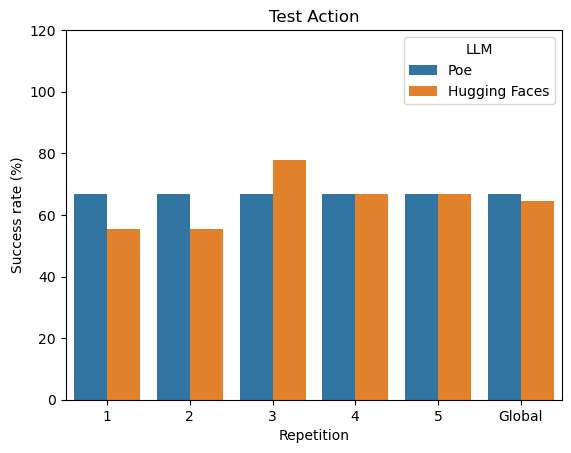

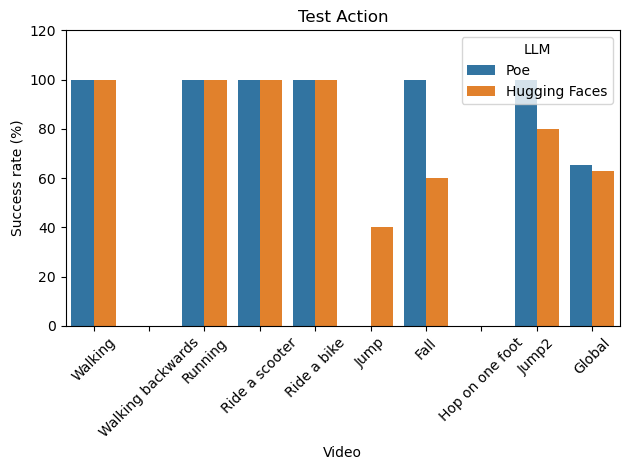

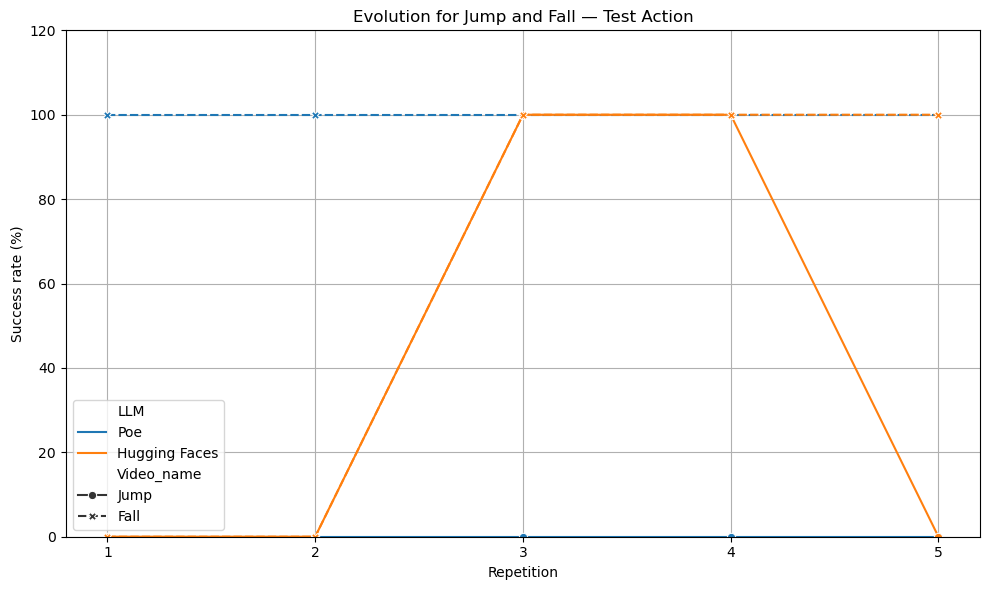

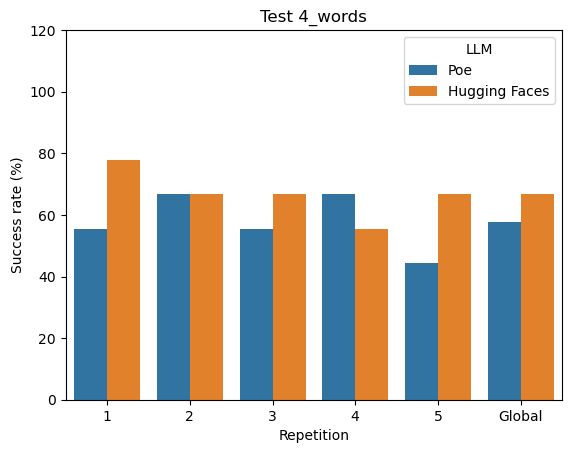

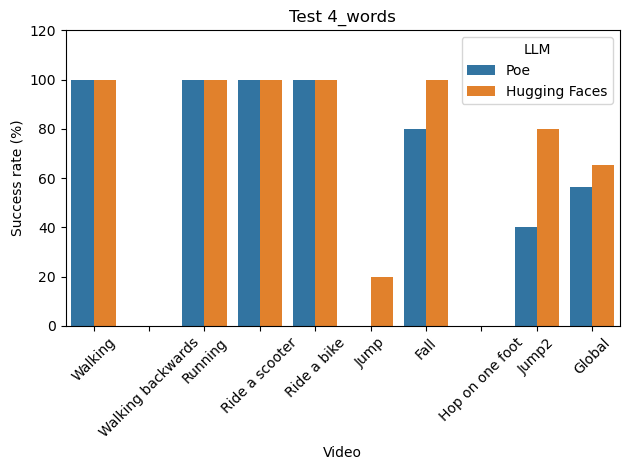

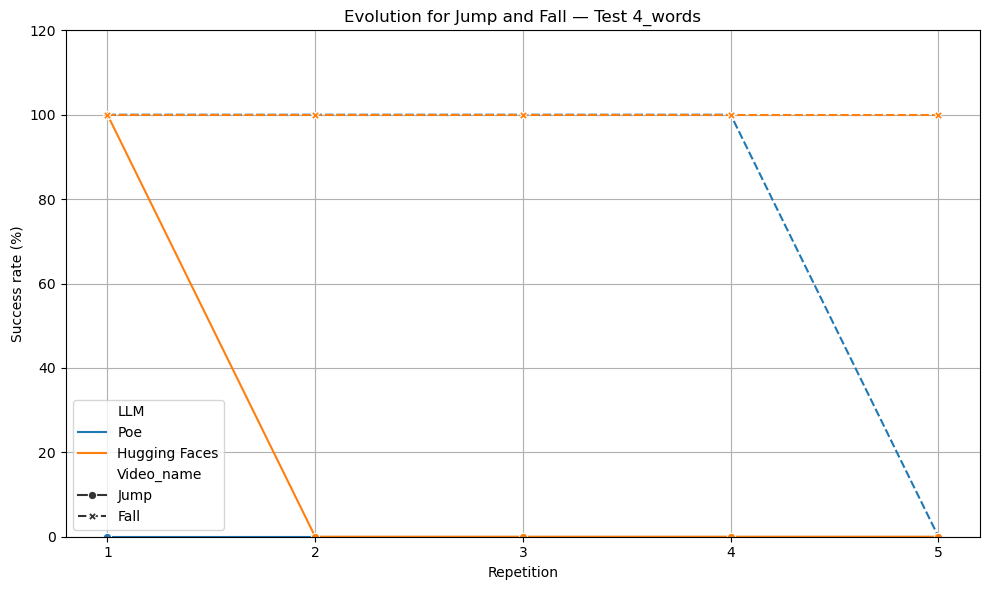

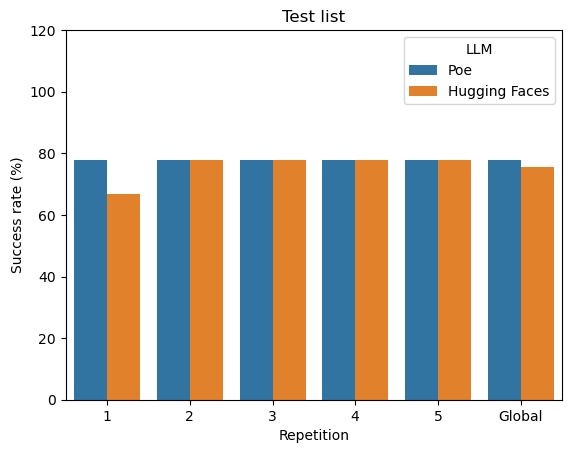

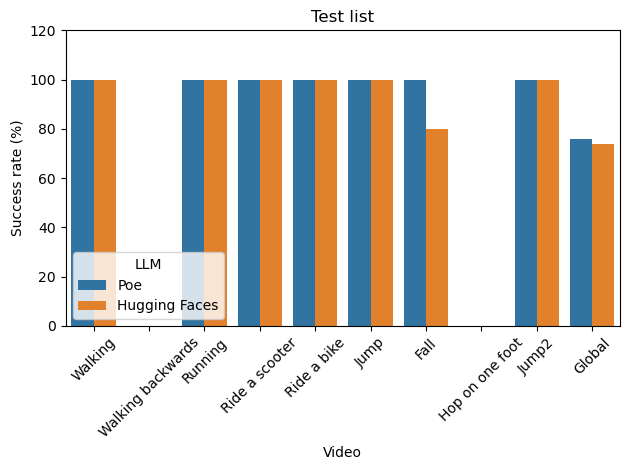

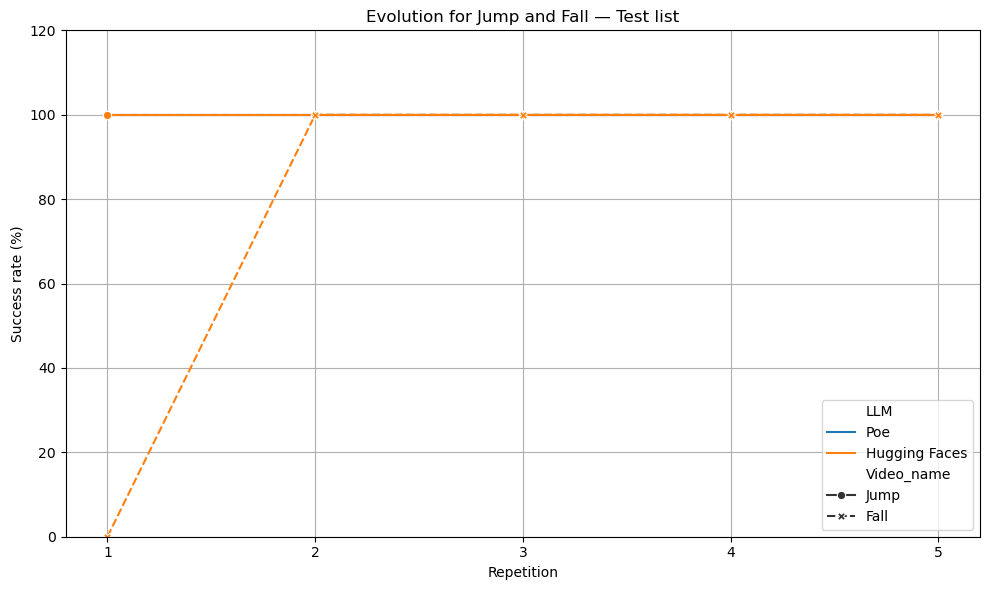

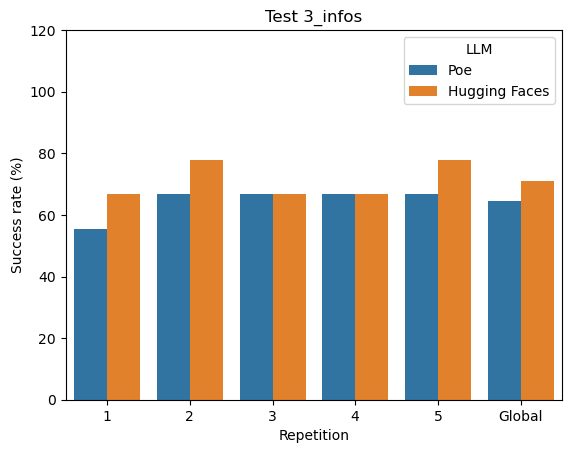

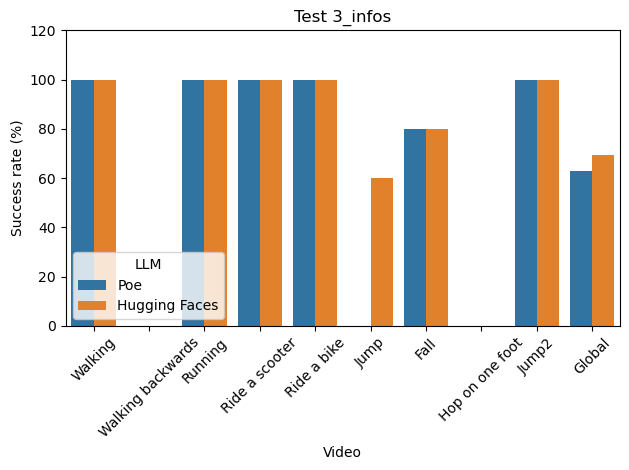

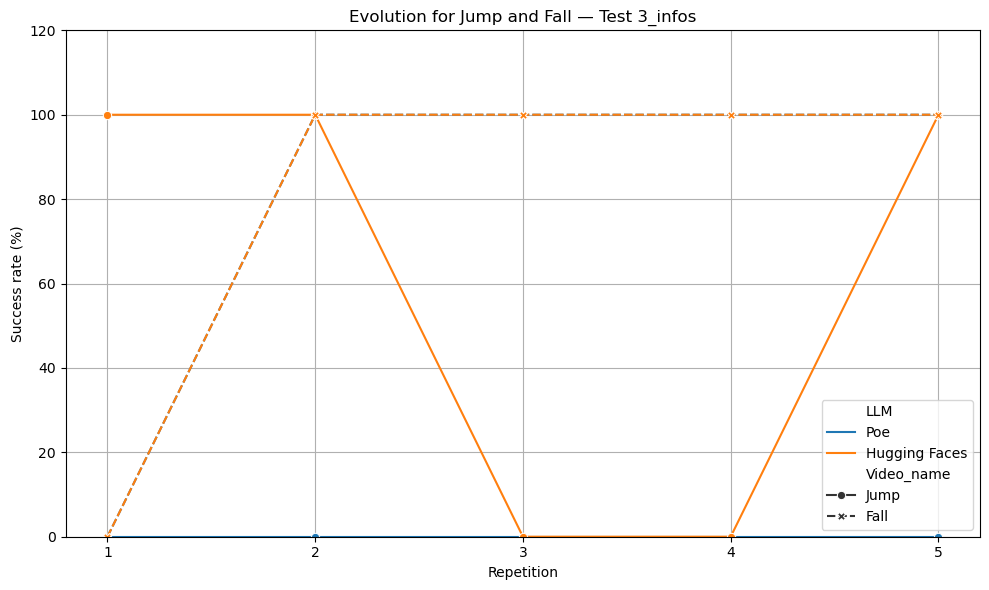

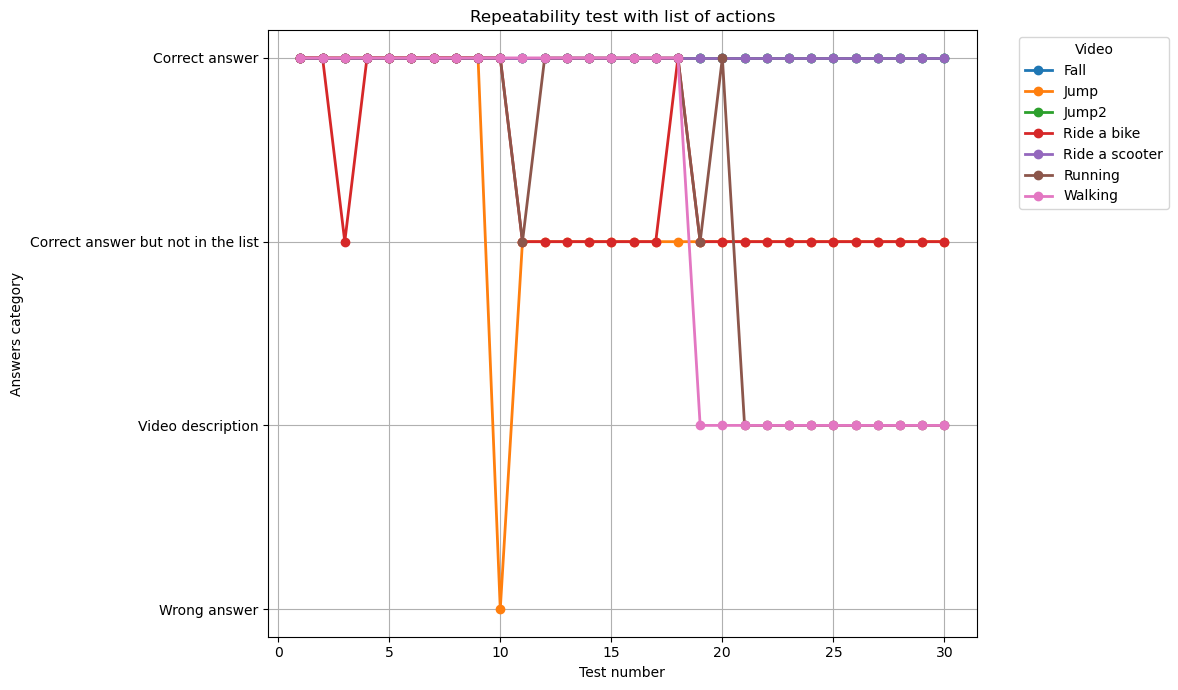

In [43]:
# Dictionary mapping video number to video name
video_names = {
    1: "Walking",
    5: "Walking backwards",
    10: "Running",
    14: "Ride a scooter",
    19: "Ride a bike",
    23: "Jump",
    7: "Jump2",
    28: "Fall",
    32: "Hop on one foot"
}

i = 0
print(dico_df.keys())  # Print all keys in dico_df for debugging

for test_type in list(dico_df.keys()):
    df_test = dico_df[test_type]
    name = list(dico_df.keys())[i]
    print(name)  # Print current test type being processed

    # --- Add a new column 'Video_name' by mapping video IDs to names ---
    df_test["Video_name"] = df_test["Video"].map(video_names)

    # Special handling for the "repeatability_list" test type
    if test_type == "repeatability_list":
        all_data = []

        # Process each unique video in the test data
        for video in df_test["Video"].dropna().unique():
            # Create a temporary DataFrame filtered by video and specific LLMs
            lst = createTemporaryDf(df_test, "Video", video, "LLM", "Poe", "Hugging Faces", critere2=False)
            df_video = lst[0].copy()

            # Check for required columns before proceeding
            if "Test" not in df_video.columns or "Answers categorie" not in df_video.columns:
                print(f"Missing columns in video {video}")
                continue

            df_video["Video"] = video

            # Repeat video name for each row to keep consistent labeling
            video_name = video_names.get(video, str(video))
            df_video["Video_name"] = [video_name] * len(df_video)

            all_data.append(df_video)

        # If no data collected, skip to next test_type
        if not all_data:
            print("No data collected.")
            continue

        # Concatenate all video DataFrames into one
        df_all = pd.concat(all_data, ignore_index=True)

        # Debug: print unique video names in combined DataFrame
        print("Video names in df_all:", df_all["Video_name"].unique())

        # Filter to first 30 tests and drop rows missing 'Answers categorie'
        df_all = df_all[df_all["Test"] <= 30]
        df_all = df_all.dropna(subset=["Answers categorie"])

        # Define the order of answer categories and map them to numeric values
        cat_order = [
            "Wrong answer",
            "Video description",
            "Correct answer but not in the list",
            "Correct answer"
        ]
        cat_to_num = {cat: i for i, cat in enumerate(cat_order)}
        df_all["Answers_categorie_num"] = df_all["Answers categorie"].map(cat_to_num)
        df_all = df_all.dropna(subset=["Answers_categorie_num"])

        if df_all.empty:
            print("No valid data to plot.")
            continue

        # Plot the repeatability test results over test number for each video
        plt.figure(figsize=(12, 7))
        for video_name, group in df_all.groupby("Video_name"):
            group = group.sort_values(by="Test")
            plt.plot(
                group["Test"],
                group["Answers_categorie_num"],
                label=video_name,
                marker='o',
                linewidth=2
            )

        plt.yticks(ticks=range(len(cat_order)), labels=cat_order)
        plt.title("Repeatability test with list of actions")
        plt.xlabel("Test number")
        plt.ylabel("Answers category")
        plt.grid(True)
        plt.legend(title="Video", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        continue  # Move to next test_type

    # --- Calculate and save success percentages by repetition (all videos combined) ---
    for rep in range(1, 6):
        lst = createTemporaryDf(df_test, "Test", rep, "LLM", "Poe", "Hugging Faces", critere2=True)
        percentPoe = calculatePercentage(lst[1], 'Action ok?', "yes", nbVideos)
        percentHF = calculatePercentage(lst[2], 'Action ok?', "yes", nbVideos)

        savePercentage(df_test, "Test", rep, "LLM", "Poe", "percentYes", percentPoe)
        savePercentage(df_test, "Test", rep, "LLM", "Hugging Faces", "percentYes", percentHF)

    # --- Add global success percentage by LLM (all repetitions) ---
    for llm in ["Poe", "Hugging Faces"]:
        df_llm = df_test[df_test["LLM"] == llm]
        global_percent = calculatePercentage(df_llm, 'Action ok?', "yes", len(df_llm))

        global_row = {
            "Test": "Global",  # Use 'Global' for x-axis label
            "LLM": llm,
            "percentYes": global_percent,
            "Video": -1,
            "Video_name": None,
            "perVideo_percentYes": None,
            "Action ok?": None
        }
        df_test = pd.concat([df_test, pd.DataFrame([global_row])], ignore_index=True)

    # --- Bar plot showing success rate by repetition including global ---
    plt.figure()
    plt.title(f"Test {name}")
    sns.barplot(data=df_test, x="Test", y="percentYes", hue="LLM", dodge=True)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_ylim(0, 120)
    plt.xlabel("Repetition")
    plt.ylabel("Success rate (%)")

    # --- Calculate and save success percentages by video ---
    for video in df_test["Video"].dropna().unique():
        if video == -1:  # Skip the global row
            continue
        lst = createTemporaryDf(df_test, "Video", video, "LLM", "Poe", "Hugging Faces", critere2=True)
        percentPoe = calculatePercentage(lst[1], 'Action ok?', "yes", nbRep)
        percentHF = calculatePercentage(lst[2], 'Action ok?', "yes", nbRep)

        savePercentage(df_test, "Video", video, "LLM", "Poe", "perVideo_percentYes", percentPoe)
        savePercentage(df_test, "Video", video, "LLM", "Hugging Faces", "perVideo_percentYes", percentHF)

    # --- Add global success percentage by video ---
    for llm in ["Poe", "Hugging Faces"]:
        df_llm = df_test[df_test["LLM"] == llm]
        global_percent = calculatePercentage(df_llm, 'Action ok?', "yes", len(df_llm))

        global_row = {
            "Test": None,
            "Video": -1,
            "Video_name": "Global",
            "LLM": llm,
            "percentYes": None,
            "perVideo_percentYes": global_percent,
            "Action ok?": None
        }
        df_test = pd.concat([df_test, pd.DataFrame([global_row])], ignore_index=True)

    # --- Bar plot showing success rate by video including global ---
    plt.figure()
    plt.title(f"Test {name}")
    sns.barplot(data=df_test, x="Video_name", y="perVideo_percentYes", hue="LLM", dodge=True)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_ylim(0, 120)
    plt.xlabel("Video")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.ylabel("Success rate (%)")

    # --- Calculate success percentages by repetition AND video (specifically for Jump & Fall) ---
    list_rows = []
    target_videos = [23, 28]  # Video IDs for Jump and Fall

    for rep in range(1, 6):
        for video in target_videos:
            for llm in ["Poe", "Hugging Faces"]:
                lst = createTemporaryDf(df_test, "Test", rep, "LLM", "Poe", "Hugging Faces", critere2=True)
                df_llm = lst[1] if llm == "Poe" else lst[2]
                df_video = df_llm[df_llm["Video"] == video]

                total_items = len(df_video)
                percent = 0 if total_items == 0 else calculatePercentage(df_video, 'Action ok?', "yes", total_items)

                list_rows.append({
                    "Test": rep,
                    "Video": video,
                    "Video_name": video_names.get(video, str(video)),
                    "LLM": llm,
                    "percentYes": percent
                })

    df_per_rep_vid = pd.DataFrame(list_rows)

    # --- Line plot showing evolution of success rate by repetition for Jump and Fall ---
    plt.figure(figsize=(10, 6))
    plt.title(f"Evolution for Jump and Fall — Test {name}")
    sns.lineplot(
        data=df_per_rep_vid,
        x="Test",
        y="percentYes",
        hue="LLM",
        style="Video_name",
        markers=True,
        dashes=True
    )
    plt.xlabel("Repetition")
    plt.ylabel("Success rate (%)")
    plt.ylim(0, 120)
    plt.xticks([1, 2, 3, 4, 5])
    plt.grid(True)
    plt.tight_layout()

    i += 1


Brouillon


In [ ]:
# def prepareDf(df_testType, x, y, hue, perRep=True, perVideo=False):
#     lst_rep=[k for k in range(1,6)]
#     lst_Video=df_testType["Video"].unique()

#     if perRep:
#         for rep in lst_rep:
#             lst_tempDF=createTemporaryDf(df_testType,"Test",rep,"LLM","Poe","Hugging Faces", critere2=True)

#             percentPoe = calculatePercentage(lst_tempDF[1],'Action ok?', "Yes", nbVideos)
#             percentHF = calculatePercentage(lst_tempDF[2],'Action ok?', "Yes", nbVideos)

#             savePercentage (df_action,"Test",rep,"LLM", "Poe", "percentYes", percentPoe)
#             savePercentage (df_action,"Test",rep,"LLM", "Hugging Faces", "percentYes", percentHF)

#     return

# df_byrep = df_action[df_action["Test"]==rep]
    # df_byrep_bypoe=df_byrep[df_byrep["LLM"]=="Poe"]
    # df_byrep_byhf=df_byrep[df_byrep["LLM"]=="Hugging Faces"]
    # occurencepoeYes = len(df_byrep_bypoe[df_byrep_bypoe['Action ok?'].isin(["Yes"])])
    # occurencehfYes = len(df_byrep_byhf[df_byrep_byhf['Action ok?'].isin(["Yes"])])
    # print(occurencepoeYes)
    # print(occurencehfYes)
    # df_action.loc[ (df_action["Test"]==rep) & (df_action["LLM"]=="Poe"),"occurenceYes"] = occurencepoeYes
    # df_action.loc[ (df_action["Test"]==rep) & (df_action["LLM"]=="Hugging Faces"),"occurenceYes"] = occurencehfYes